In [127]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
import string
import joblib
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
import spacy
nltk.download('punkt')
nltk.download("stopwords")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [128]:
# Load dataset
df_train = pd.read_csv('data/train.csv', encoding='Windows-1252')
df_test = pd.read_csv('data/test.csv', encoding='Windows-1252')
# Quick preview of the data

# Convert the 'comment' column to string type
df_train["comment"] = df_train["comment"].astype(str)
df_test["comment"] = df_test["comment"].astype(str)
df_train.head()


,comment,language,sentiment
0,mas malaki pa ang sainyo kontra sa isang long ...,Filipino,negative
1,medyo may gasgas di naka bubble wrap bad,Filipino,negative
2,photo and video not related to the product tha...,English,negative
3,thanks seller medyo maliit sya but it looks li...,English,negative
4,so disappointed waste of time and money cogs t...,English,negative


In [129]:
print(df_train.shape)
print("")
df_train.info()

(4183, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4183 entries, 0 to 4182
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   comment    4183 non-null   object
 1   language   4183 non-null   object
 2   sentiment  4183 non-null   object
dtypes: object(3)
memory usage: 98.2+ KB


In [130]:
nlp = spacy.load("en_core_web_sm")
def create_vectorizer():
    # Custom Tagalog stop words
    tagalog_stopwords = [
        "akin", "aking", "ako", "alin", "am", "amin", "aming", "ang", "ano", "anumang", "apat", "at", "atin",
        "ating", "ay", "bababa", "bago", "bakit", "bawat", "bilang", "dahil", "dalawa", "dapat", "din", "dito",
        "doon", "gagawin", "gayunman", "ginagawa", "ginawa", "ginawang", "gumawa", "gusto", "habang", "hanggang",
        "huwag", "iba", "ibaba", "ibabaw", "ibig", "ikaw", "ilagay", "ilalim", "ilan", "inyong", "isa",
        "isang", "itaas", "ito", "iyo", "iyon", "iyong", "ka", "kahit", "kailangan", "kailanman", "kami", "kanila",
        "kanilang", "kanino", "kanya", "kanyang", "kapag", "kapwa", "karamihan", "katiyakan", "katulad", "kaya",
        "kaysa", "ko", "kong", "kulang", "kumuha", "kung", "laban", "lahat", "lamang", "likod", "lima", "maaari",
        "maaaring", "maging", "mahusay", "makita", "marami", "marapat", "masyado", "may", "mayroon", "mga", "minsan",
        "mismo", "mula", "muli", "na", "nabanggit", "naging", "nagkaroon", "nais", "nakita", "namin", "napaka", "narito",
        "nasaan", "ng", "ngayon", "ni", "nila", "nilang", "nito", "niya", "niyang", "noon", "o", "pa", "paano", "pababa",
        "paggawa", "pagitan", "pagkakaroon", "pagkatapos", "palabas", "pamamagitan", "panahon", "pangalawa", "para",
        "paraan", "pareho", "pataas", "pero", "pumunta", "pumupunta", "sa", "saan", "sabi", "sabihin", "sarili", "sila",
        "sino", "siya", "tatlo", "tayo", "tulad", "tungkol", "una", "walang", "nako", "nag", "pag", "thi", "una", "lng", "ga",
        "yung", "i", "doy", "ive", "kaso", "ma", "sana", "sya", "naman", "xa", "po", "lang", "lamang", "tapos", "kayo",
        "nga","kang", "im", "making", "quality", "really"
    ]

    # Initialize CountVectorizer to get English stop words
    vectorizer = CountVectorizer(stop_words='english')
    english_stop_words = vectorizer.get_stop_words()  # Get the English stop words
    # Combine English and Tagalog stop words
    combined_stop_words = tagalog_stopwords + list(english_stop_words)

    # Create a new CountVectorizer with the combined stop words
    vectorizer_with_combined_stopwords = CountVectorizer(stop_words=combined_stop_words, ngram_range=(1,3))
    
    return vectorizer_with_combined_stopwords

# data preprocessing
def pre_process(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special chars and numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    text = re.sub(r'\b(\w+)\s+\1\b', r'\1', text)  # Remove repeated words
    comment_review = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    doc = nlp(comment_review)
    
    # Lemmatize each token (word), remove stop words and punctuation
    lemmatized_text = " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
    
    return lemmatized_text

# Calculate word count
def calculate_word_counts(texts):
    # Apply preprocessing and create vectorizer
    preprocessed_texts = texts.apply(pre_process)  # Pre-process the texts
    vectorizer = create_vectorizer()  # Initialize the vectorizer

    # Fit and transform the preprocessed texts to get the word counts
    X = vectorizer.fit_transform(preprocessed_texts)  # Sparse matrix

    # Get word counts directly from the sparse matrix
    word_count_array = X.sum(axis=0).A1  # Sum counts for each word and flatten
    words = vectorizer.get_feature_names_out()  # Get feature names (words)

    word_count = dict(zip(words, word_count_array))  # Create a dictionary mapping words to their counts

    return word_count

In [131]:
# Preprocess datasets
df_train['processed_comments'] = df_train['comment'].apply(pre_process)
df_test['processed_comments'] = df_test['comment'].apply(pre_process)

df_train['processed_comments'] = df_train['comment']
df_test['processed_comments'] = df_test['comment']

vectorizer = create_vectorizer()
# Reset index to ensure alignment
df_test = df_test.dropna(subset=['processed_comments', 'sentiment']).reset_index(drop=True)
X_train = vectorizer.fit_transform(df_train['processed_comments'])
X_test = vectorizer.transform(df_test['processed_comments'])

# Train Naive Bayes model
model = MultinomialNB()
model.fit(X_train, df_train['sentiment'])

#predict
y_pred = model.predict(X_test)
y_true = df_test['sentiment']

# Exports the model and vectorizer into .joblib
joblib.dump(model, 'model/Naive_Bayes_model.joblib')
joblib.dump(vectorizer, 'model/vectorizer.joblib')

['model/vectorizer.joblib']

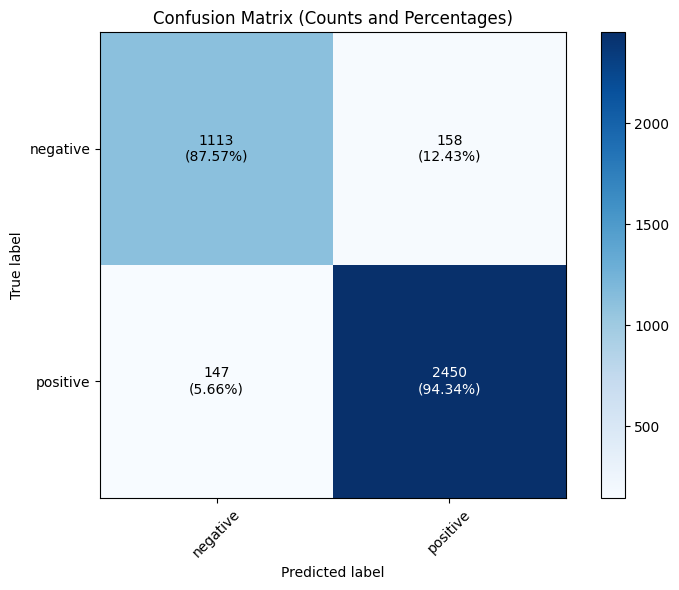

In [132]:
classifier = svm.SVC(kernel="linear", C=1).fit(X_test, y_pred)
np.set_printoptions(precision=2)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100  # Convert to percentages

# Plot confusion matrix with counts and percentages
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title("Confusion Matrix (Counts and Percentages)")
plt.colorbar(im, ax=ax)

# Display labels
classes = classifier.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Annotate each cell with counts and percentages
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i,
            f"{cm[i, j]}\n({cm_percentage[i, j]:.2f}%)",  # Counts and percentages
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

# Add axis labels
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [133]:
# classification report
report = classification_report(y_true, y_pred, labels=['positive', 'negative'])
print(report)

# Display Accuracy score
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy Score: {accuracy:.2f}")

              precision    recall  f1-score   support

    positive       0.94      0.94      0.94      2597
    negative       0.88      0.88      0.88      1271

    accuracy                           0.92      3868
   macro avg       0.91      0.91      0.91      3868
weighted avg       0.92      0.92      0.92      3868

Accuracy Score: 0.92


In [134]:
# Calculate word counts for tweets with different sentiments
word_count_positive = calculate_word_counts(df_train[df_train['sentiment'] == 'positive']['comment'])
word_count_negative = calculate_word_counts(df_train[df_train['sentiment'] == 'negative']['comment'])
word_count_negative.items()

dict_items([('abala', np.int64(1)), ('abala isasauli', np.int64(1)), ('abala isasauli bwisitfalse', np.int64(1)), ('ability', np.int64(1)), ('ability stop', np.int64(1)), ('ability stop quickly', np.int64(1)), ('able', np.int64(2)), ('able rely', np.int64(1)), ('able rely flexibility', np.int64(1)), ('able tighten', np.int64(1)), ('able tighten rare', np.int64(1)), ('abot', np.int64(2)), ('abot cog', np.int64(1)), ('abot cog need', np.int64(1)), ('abroad', np.int64(1)), ('abroad week', np.int64(1)), ('abruptly', np.int64(1)), ('abruptly cause', np.int64(1)), ('abruptly cause jerk', np.int64(1)), ('absorb', np.int64(13)), ('absorb bump', np.int64(2)), ('absorb bump hope', np.int64(1)), ('absorb bump ride', np.int64(1)), ('absorb shock', np.int64(11)), ('absorb shock effectively', np.int64(1)), ('absorb shock expect', np.int64(3)), ('absorb shock make', np.int64(4)), ('absorb shock properly', np.int64(1)), ('absorber', np.int64(2)), ('absorber leak', np.int64(2)), ('absorber leak oil', n

In [135]:
# Convert word counts to DataFrames for better visualization
word_count_positive_df = pd.DataFrame(word_count_positive.items(), columns=['Word', 'Count'])
word_count_negative_df = pd.DataFrame(word_count_negative.items(), columns=['Word', 'Count'])

In [136]:
# Sort and select the top 20 words for each sentiment class
top_positive_words = word_count_positive_df.sort_values(by='Count', ascending=False).head(20)
top_negative_words = word_count_negative_df.sort_values(by='Count', ascending=False).head(20)

In [137]:
# Display the top words and their counts for each sentiment class
print("Word Counts - Positive Sentiment:")
print(top_positive_words.head())

print("\nWord Counts - Negative Sentiment:")
print(top_negative_words.head())

Word Counts - Positive Sentiment:
          Word  Count
6132      good    562
13901  product    325
15103     ride    288
17197   smooth    225
736     bagong    212

Word Counts - Negative Sentiment:
        Word  Count
6409   hindi    498
1529   brake    376
13863   ride    309
1009    bike    239
4764    feel    211


In [138]:
# Display the top words for each sentiment class - Positive
print("Top 20 Words - Positive Sentiment:")
print()
# Apply background gradient styling and display the DataFrame
styled_positive_words = top_positive_words.style.background_gradient(cmap='Greens')
styled_positive_words

Top 20 Words - Positive Sentiment:



,Word,Count
6132,good,562
13901,product,325
15103,ride,288
17197,smooth,225
736,bagong,212
7298,hindi,196
16030,seller,191
19074,thank,184
17463,sobrang,173
1582,brake,172


In [139]:
# Display the top words for each sentiment class - Negative
print("\nTop 20 Words - Negative Sentiment:")
print()
# Apply background gradient styling and display the DataFrame
styled_negative_words = top_negative_words.style.background_gradient(cmap='Reds')
styled_negative_words



Top 20 Words - Negative Sentiment:



,Word,Count
6409,hindi,498
1529,brake,376
13863,ride,309
1009,bike,239
4764,feel,211
9636,make,187
11177,new,182
15763,sobrang,165
18087,wala,111
5536,gear,109


In [ ]:
def classify_tokens(comment):
    # Tokenize and vectorize the entire comment using the vectorizer (including n-grams)
    tokens_vectorized = vectorizer.transform([comment])  # Vectorize the entire comment
    token_sentiments = {}

    # Get the feature names (n-grams) from the vectorizer
    feature_names = vectorizer.get_feature_names_out()

    # For each token (n-gram), check if it's present in the vectorized representation
    for idx in range(tokens_vectorized.shape[1]):  # Loop through all feature indices
        token_vector = tokens_vectorized[0, idx]  # Get the count for the n-gram at index idx
        if token_vector > 0:  # If the n-gram exists in the comment
            token = feature_names[idx]  # Get the actual n-gram (token)
            prediction = model.predict(tokens_vectorized)  # Predict the sentiment of the entire comment
            token_sentiments[token] = prediction[0]

    return token_sentiments

def classify_comment(comment):
    comment_vectorized = vectorizer.transform([comment])
    prediction = model.predict(comment_vectorized)
    return prediction[0]  # Predict for the entire comment


# Example usage
for comment in df_test['processed_comments']:  # Assuming you have a column 'processed_comments'
    sentiment = classify_comment(comment)  # Classify sentiment for each comment
    print(f"Original Comment: {comment}")
    print(f"Predicted Sentiment: {sentiment}\n")

# Example usage
for comment in df_test['processed_comments']:
    print(f"Original Comment: {comment}")
    token_sentiments = classify_tokens(pre_process(comment))
    print(f"Token Sentiments: {token_sentiments}\n")


Original Comment: all good naman maganda ang quality at maayos ang packaging responsive naman si seller sa mga inquiries at ginawa yung mga special requests ko solid
Predicted Sentiment: positive

Original Comment: usage good beautiful good quality reasonable priceshop fast delivery shipping service is good quick usage good job quality has standards works well strong quality strong and durable have standards
Predicted Sentiment: positive

Original Comment: never ako na disappoint sa company na ito maganda ang pag kakapackage always complete ang order at walang mali
Predicted Sentiment: positive

Original Comment: usage good quality work has standards works well strongly strongly beautiful good quality reasonable price shop fast delivery good service delivery service quickly
Predicted Sentiment: positive

Original Comment: perfect
Predicted Sentiment: positive

Original Comment: thanks po seller
Predicted Sentiment: positive

Original Comment: maganda gamitin lalo na kung pogi yung guma